In [1]:
import copy
import csv
import datetime
import math
import os
import statistics

from collections import defaultdict

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

from IPython import display

# Load Data

In [2]:
"""Steps to download the data locally
1) Download the `Logs` folder from Google Drive: https://drive.google.com/drive/folders/17qVeGr-oWAaon876jT_5HkJuAzBU8p-f
2) Unzip it, and move it into Assets/Logs in FlatWorld
"""

files = os.listdir("../Logs")
files.sort()
for file in files:
    if file.endswith(".csv"):
        with open('../Logs/' + file) as f:
            reader = csv.reader(f)
            first_line = next(reader)
            for row in reader:
                last_line = row
            start_time = datetime.datetime.strptime(first_line[0], "%m/%d/%Y %H:%M:%S.%f")
            end_time = datetime.datetime.strptime(last_line[0], "%m/%d/%Y %H:%M:%S.%f")
            print(file, str(end_time - start_time), start_time, end_time)


hand_log1542048814863.csv 0:01:04.768000 2018-11-12 10:53:34.890000 2018-11-12 10:54:39.658000
hand_log1542048995151.csv 0:00:20.730000 2018-11-12 10:56:35.181000 2018-11-12 10:56:55.911000
hand_log1542049250286.csv 0:02:07.365000 2018-11-12 11:00:50.321000 2018-11-12 11:02:57.686000
hand_log1542049392458.csv 0:02:06.582000 2018-11-12 11:03:12.496000 2018-11-12 11:05:19.078000
hand_log1542049530393.csv 0:02:40.014000 2018-11-12 11:05:30.433000 2018-11-12 11:08:10.447000
hand_log1542049693653.csv 0:02:02.406000 2018-11-12 11:08:13.696000 2018-11-12 11:10:16.102000
hand_log1542049895342.csv 0:00:25.061000 2018-11-12 11:11:35.385000 2018-11-12 11:12:00.446000
hand_log1542050067354.csv 0:00:20.589000 2018-11-12 11:14:27.396000 2018-11-12 11:14:47.985000
hand_log1542050109195.csv 0:00:36.023000 2018-11-12 11:15:09.235000 2018-11-12 11:15:45.258000
hand_log1542050233041.csv 0:00:32.603000 2018-11-12 11:17:13.084000 2018-11-12 11:17:45.687000
hand_log1542050419916.csv 0:01:36.479000 2018-11-1

In [3]:
# p1-p3 identified from screencapture timestamps: https://drive.google.com/drive/folders/1w1Wd1uBGsqCdc-RZVZTJ3oocitcwuBaS
p1_file = '../Logs/hand_log1542067070161.csv' # 16:01
p2_file = '../Logs/hand_log1542068380157.csv' # 16:27
p3_file = '../Logs/hand_log1542072558972.csv' # 17:35
p4_file = '../Logs/hand_log1542136320496.csv'
p5_file = '../Logs/hand_log1542145644623.csv'
files = [p1_file, p2_file, p3_file, p4_file, p5_file]

In [4]:
for file in files:
    event_counts = defaultdict(int)
    with open(file) as f:
        reader = csv.reader(f)
        for row in reader:
            event_counts[row[1]] += 1
    print(event_counts)

defaultdict(<class 'int'>, {'hand_6dof': 231656, 'object_6dof': 115761, 'experiment_changed': 22})
defaultdict(<class 'int'>, {'hand_6dof': 237156, 'object_6dof': 118515, 'experiment_changed': 22})
defaultdict(<class 'int'>, {'hand_6dof': 226008, 'object_6dof': 112941, 'experiment_changed': 22})
defaultdict(<class 'int'>, {'hand_6dof': 164680, 'object_6dof': 82276, 'experiment_changed': 22})
defaultdict(<class 'int'>, {'hand_6dof': 355954, 'object_6dof': 177839, 'experiment_changed': 79})


# Util stuff

In [5]:
def parse_time(s):
    return datetime.datetime.strptime(s, "%m/%d/%Y %H:%M:%S.%f")

def new_events_entry(start_time):
    return {'start_time': start_time, 'object_events': []}

def parse_event(event):
    return {
        'time': parse_time(event[0]),
        'type': event[1],
        'x': float(event[2]),
        'y': float(event[3]),
        'z': float(event[4]),
        'rx': float(event[5]),
        'ry': float(event[6]),
        'rz': float(event[7]),
    }

# Participant -> [start_time, end_time, [hand_events], [object_events]]
def group_data(file):
    with open(file) as f:
        reader = csv.reader(f)
        events = [new_events_entry(None)]
        for row in reader:
            if not events[0]['start_time']:
                events[0]['start_time'] = parse_time(row[0]) 
            if row[1] == 'experiment_changed':
                events[-1]['end_time'] = parse_time(row[0])
                events.append(new_events_entry(parse_time(row[0])))
                # Add event data
#             elif row[1] == 'hand_6dof':
#                 events[-1]['hand_events'].append(parse_event(row))
            elif row[1] == 'object_6dof':
                events[-1]['object_events'].append(parse_event(row))
        events[-1][end_time] = parse_time(row[0])
    return events

p1_data = group_data(p1_file)
p2_data = group_data(p2_file)
p3_data = group_data(p3_file)
p4_data = group_data(p4_file)
p5_data = group_data(p5_file)



# TODO: Do something to map correctly (by hand?) to experiment conditions.

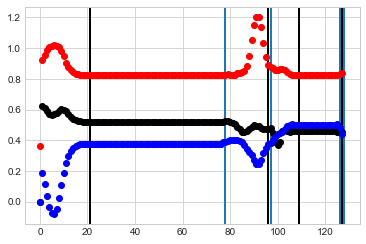

In [6]:
# Let's make sure the y axis is what we expect
# Let's also try and detect the start and end of the object moving.

def approx_eq(a, b):
    return abs(a-b) < .001

xs = []
ys = []
zs = []
for i, event in enumerate(p1_data[6]['object_events']):
    if i%10 == 0:
        xs.append(event['x'])
        ys.append(event['y'])
        zs.append(event['z'])
    
    if len(xs) > 3:
        if not approx_eq(xs[-1], xs[-2]) and approx_eq(xs[-2], xs[-3]):
            plt.axvline(x=len(xs))
        if approx_eq(xs[-1], xs[-2]) and not approx_eq(xs[-2], xs[-3]):
            plt.axvline(x=len(xs), color='black')


plt.plot(range(len(xs)), xs, 'o', color='black') 
plt.plot(range(len(xs)), ys, 'o', color='red') # Confirmed as vertical direction!
plt.plot(range(len(xs)), zs, 'o', color='blue')



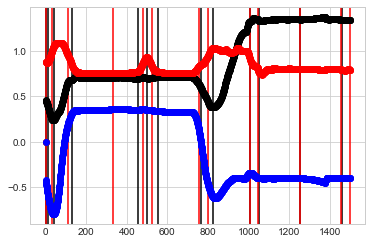

0 : [(0, 1), (11, 30), (41, 112), (131, 332), (453, 481), (501, 525), (553, 754), (766, 801), (825, 1005), (1007, 1047), (1050, 1251), (1255, 1456), (1462, 1499)]
453
481


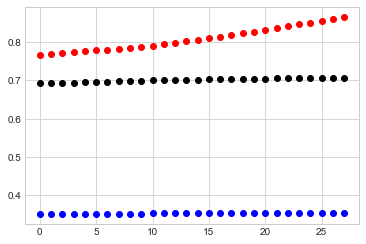

y


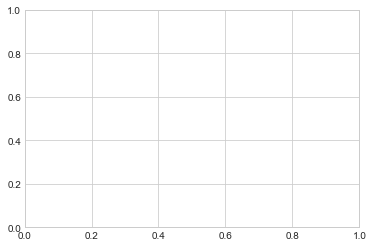

In [136]:
# This code is all only necessary for manual trimming at the start.
# Never needs to be run again :)
"""
def is_moving(xs, ys, zs):
    return ((not almost_eq(xs[-1], xs[-2]) and almost_eq(xs[-2], xs[-3])) or
        (not almost_eq(ys[-1], ys[-2]) and almost_eq(ys[-2], ys[-3])) or
        (not almost_eq(zs[-1], zs[-2]) and almost_eq(zs[-2], zs[-3]))
        )

def almost_eq(a, b):
    return abs(a-b) < .001

def add_trim_metadata(data):
    for trial_num, trial in enumerate(data):
        xs = []
        ys = []
        zs = []
        # Keep track of the relevant ranges
        ranges = []
        start_v_lines = [0]
        end_v_lines = []
        curr_range_start = 0
        start_y = 0

        for i, event in enumerate(trial['object_events']):
            xs.append(event['x'])
            ys.append(event['y'])
            zs.append(event['z'])
            if curr_range_start is not None:
                if abs(ys[-1] - start_y) >= .1 or i - curr_range_start > 200:
                    ranges.append((curr_range_start, i))
                    curr_range_start = None
                    end_v_lines.append(i)
            else:
                if len(xs) >= 3 and is_moving(xs[-3:], ys[-3:], zs[-3:]):
                    curr_range_start = i
                    start_v_lines.append(i)
                    start_y = ys[-1]
        if curr_range_start:
            ranges.append((curr_range_start, i))
            end_v_lines.append(i)

        valid = 'n'
        while valid != 'y':
            for i in start_v_lines:
                plt.axvline(x=i, color='black')
            for i in end_v_lines:
                plt.axvline(x=i, color='red')
            
            plt.plot(range(len(xs)), xs, 'o', color='black') 
            plt.plot(range(len(xs)), ys, 'o', color='red') # Confirmed as vertical direction!
            plt.plot(range(len(xs)), zs, 'o', color='blue')
            display.display(plt.gcf())

            print(trial_num, ':', ranges)
#             if 'end_i' in trial:
#                 print(trial['start_i'], trial['end_i'])
            start = int(input())
            end = int(input())

            plt.cla()

            plt.plot(range(end-start), xs[start:end], 'o', color='black') 
            plt.plot(range(end-start), ys[start:end], 'o', color='red') # Confirmed as vertical direction!
            plt.plot(range(end-start), zs[start:end], 'o', color='blue')
            display.display(plt.gcf())

            valid = input()

#             trial['object_events'] = trial['object_events'][start:end]

            plt.cla()
        trial['start_i'] = start
        trial['end_i'] = end


def custom_add_trim_metadata(data, trial_i, start_i, end_i):
    copy_data = copy.deepcopy(data)
    copy_data = [copy_data[trial_i]]
    copy_data[0]['object_events'] = copy_data[0]['object_events'][start_i:end_i]
    add_trim_metadata(copy_data)
    data[trial_i]['start_i'] = copy_data[0]['start_i'] + start_i
    data[trial_i]['end_i'] = copy_data[0]['end_i'] + start_i
    return copy_data

# add_trim_metadata(p5_data)
# custom_add_trim_metadata(p5_data, 63, 0, 1500)

# custom_add_trim_metadata(p5_data, 43, 1100, 1300)
# custom_add_trim_metadata(p5_data, 51, 170, 220)
# custom_add_trim_metadata(p5_data, 75, 400, 600)
# custom_add_trim_metadata(p5_data, 78, 410, 600)
custom_add_trim_metadata(p5_data, 79, 0, 1500)
pass
"""

In [145]:
# for i, e in enumerate(p1_data):
#     e['start_i'] = e['object_events'][-1]['start_i']
#     e['end_i'] = e['object_events'][-1]['start_i']
#     print(i, e.keys())
# #     print(e['start_i'], e['end_i'])
vals = [0, 0, 0,0,0,4904,765,319,1502,541,229,1012,503,171,1099,436,406,1115,271,427,1278,447,522]

for i, e in enumerate(p1_data):
    e['start_i'] = vals[i]

### One-off trim set-up

In [7]:
"""def constant_string_helper(variable_name, data, hand_rep_order, object_type_order, object_rep_order):
    ret_str = "%s = {\n" % variable_name
    for i, trial in enumerate(data):
        if trial['start_i']:
            hand_rep = hand_rep_order[(i%23-5)//6]
            object_type = object_type_order[(i%23-5)%6//3]
            object_rep = object_rep_order[(i%23-5)%3]
            ret_str += "  {}: ('{}', '{}', '{}', {}),\n".format(i, hand_rep, object_type, object_rep, trial['start_i'])
    ret_str += "}"
    print(ret_str)

constant_string_helper("P1_METADATA", p1_data, ['puck', 'control', 'static'], ['cup', 'controller'], ['control', 'heatmap', 'shell'])
constant_string_helper("P2_METADATA", p2_data, ['control', 'static', 'puck'], ['cup', 'controller'], ['shell', 'heatmap', 'control'])
constant_string_helper("P3_METADATA", p3_data, ['static', 'control', 'puck'], ['controller', 'cup'], ['heatmap', 'shell', 'control'])
constant_string_helper("P4_METADATA", p4_data, ['control', 'puck', 'static'], ['controller', 'cup'], ['control', 'heatmap', 'shell'])
constant_string_helper("P5_METADATA", p5_data, ['puck', 'static', 'control'], ['cup', 'controller'], ['heatmap', 'control', 'shell'])
"""

KeyError: 'start_i'

In [8]:
P1_METADATA = {
  5: ('puck', 'cup', 'control', 4904),
  6: ('puck', 'cup', 'heatmap', 765),
  7: ('puck', 'cup', 'shell', 319),
  8: ('puck', 'controller', 'control', 1502),
  9: ('puck', 'controller', 'heatmap', 541),
  10: ('puck', 'controller', 'shell', 229),
  11: ('control', 'cup', 'control', 1012),
  12: ('control', 'cup', 'heatmap', 503),
  13: ('control', 'cup', 'shell', 171),
  14: ('control', 'controller', 'control', 1099),
  15: ('control', 'controller', 'heatmap', 436),
  16: ('control', 'controller', 'shell', 406),
  17: ('static', 'cup', 'control', 1115),
  18: ('static', 'cup', 'heatmap', 271),
  19: ('static', 'cup', 'shell', 427),
  20: ('static', 'controller', 'control', 1278),
  21: ('static', 'controller', 'heatmap', 447),
  22: ('static', 'controller', 'shell', 522),
}
P2_METADATA = {
  5: ('control', 'cup', 'shell', 2146),
  6: ('control', 'cup', 'heatmap', 791),
  7: ('control', 'cup', 'control', 987),
  8: ('control', 'controller', 'shell', 1457),
  9: ('control', 'controller', 'heatmap', 701),
  10: ('control', 'controller', 'control', 659),
  11: ('static', 'cup', 'shell', 1041),
  12: ('static', 'cup', 'heatmap', 543),
  13: ('static', 'cup', 'control', 388),
  14: ('static', 'controller', 'shell', 431),
  15: ('static', 'controller', 'heatmap', 754),
  16: ('static', 'controller', 'control', 511),
  17: ('puck', 'cup', 'shell', 1481),
  18: ('puck', 'cup', 'heatmap', 400),
  19: ('puck', 'cup', 'control', 449),
  20: ('puck', 'controller', 'shell', 1030),
  21: ('puck', 'controller', 'heatmap', 403),
  22: ('puck', 'controller', 'control', 560),
}
P3_METADATA = {
  5: ('static', 'controller', 'heatmap', 5025),
  6: ('static', 'controller', 'shell', 770),
  7: ('static', 'controller', 'control', 574),
  8: ('static', 'cup', 'heatmap', 1025),
  9: ('static', 'cup', 'shell', 512),
  10: ('static', 'cup', 'control', 452),
  11: ('control', 'controller', 'heatmap', 1564),
  12: ('control', 'controller', 'shell', 528),
  13: ('control', 'controller', 'control', 364),
  14: ('control', 'cup', 'heatmap', 960),
  15: ('control', 'cup', 'shell', 299),
  16: ('control', 'cup', 'control', 373),
  17: ('puck', 'controller', 'heatmap', 2350),
  18: ('puck', 'controller', 'shell', 341),
  19: ('puck', 'controller', 'control', 393),
  20: ('puck', 'cup', 'heatmap', 972),
  21: ('puck', 'cup', 'shell', 354),
  22: ('puck', 'cup', 'control', 374),
}
P4_METADATA = {
  5: ('control', 'controller', 'control', 1825),
  6: ('control', 'controller', 'heatmap', 802),
  7: ('control', 'controller', 'shell', 487),
  8: ('control', 'cup', 'control', 1105),
  9: ('control', 'cup', 'heatmap', 368),
  10: ('control', 'cup', 'shell', 316),
  11: ('puck', 'controller', 'control', 2880),
  12: ('puck', 'controller', 'heatmap', 672),
  13: ('puck', 'controller', 'shell', 359),
  14: ('puck', 'cup', 'control', 817),
  15: ('puck', 'cup', 'heatmap', 300),
  16: ('puck', 'cup', 'shell', 293),
  17: ('static', 'controller', 'control', 1732),
  18: ('static', 'controller', 'heatmap', 396),
  19: ('static', 'controller', 'shell', 420),
  20: ('static', 'cup', 'control', 676),
  21: ('static', 'cup', 'heatmap', 622),
  22: ('static', 'cup', 'shell', 299),
}
P5_METADATA = {
  34: ('static', 'cup', 'heatmap', 4651),
  35: ('static', 'cup', 'control', 1535),
  36: ('static', 'cup', 'shell', 785),
  37: ('static', 'controller', 'heatmap', 1296),
  38: ('static', 'controller', 'control', 631),
  39: ('static', 'controller', 'shell', 637),
  40: ('control', 'cup', 'heatmap', 1266),
  41: ('control', 'cup', 'control', 628),
  42: ('control', 'cup', 'shell', 409),
  43: ('control', 'controller', 'heatmap', 1123),
  44: ('control', 'controller', 'control', 603),
  45: ('control', 'controller', 'shell', 441),
  74: ('puck', 'cup', 'heatmap', 1373),
  75: ('puck', 'cup', 'control', 436),
  76: ('puck', 'cup', 'shell', 356),
  77: ('puck', 'controller', 'heatmap', 878),
  78: ('puck', 'controller', 'control', 440),
  79: ('puck', 'controller', 'shell', 453),
}

In [29]:
HEIGHT_THRESH = .02 # 2cm

def trimmed_data(data, metadata, participant):
    new_data = []
    for trial_i, meta in metadata.items():
        new_data.append(copy.deepcopy(data[trial_i]))
        new_data[-1]['hand_rep'] = meta[0]
        new_data[-1]['object_type'] = meta[1]
        new_data[-1]['object_rep'] = meta[2]
        new_data[-1]['participant'] = participant
        i = meta[3]
        start_y = new_data[-1]['object_events'][i]['y']
        while True:
            i += 1
            if new_data[-1]['object_events'][i]['y'] - start_y >= HEIGHT_THRESH:
                break
        new_data[-1]['object_events'] = new_data[-1]['object_events'][meta[3]:i]
    return new_data

p1_trimmed_data = trimmed_data(p1_data, P1_METADATA, 'p1')
p2_trimmed_data = trimmed_data(p2_data, P2_METADATA, 'p2')
p3_trimmed_data = trimmed_data(p3_data, P3_METADATA, 'p3')
p4_trimmed_data = trimmed_data(p4_data, P4_METADATA, 'p4')
p5_trimmed_data = trimmed_data(p5_data, P5_METADATA, 'p5')

In [10]:
# Sanity Checks.

j = 0
for i, te in enumerate(p4_trimmed_data):
    while p4_data[j]['end_i'] - p4_data[j]['start_i'] == 1:
        j += 1
    assert(p4_data[j]['end_i'] - p4_data[j]['start_i'] > len(te['object_events']))
    j += 1

KeyError: 'end_i'

# Distance Offset

### By Participant

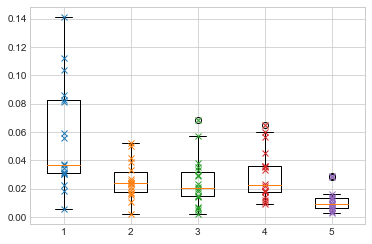

In [30]:
def dist(events):
    last_event = None
    total_dist = 0
    for e in events:
        if last_event:
            total_dist += math.sqrt((e['x'] - last_event['x'])**2 + (e['z'] - last_event['z'])**2)
        last_event = e
    return total_dist

p1_vals = []
for e in p1_trimmed_data:
    p1_vals.append(dist(e['object_events']))

p2_vals = []
for e in p2_trimmed_data:
    p2_vals.append(dist(e['object_events']))

p3_vals = []
for e in p3_trimmed_data:
    p3_vals.append(dist(e['object_events']))

p4_vals = []
for e in p4_trimmed_data:
    p4_vals.append(dist(e['object_events']))

p5_vals = []
for e in p5_trimmed_data:
    p5_vals.append(dist(e['object_events']))

    
    
plt.boxplot([p1_vals, p2_vals, p3_vals, p4_vals, p5_vals], positions=[1,2,3,4,5])
plt.plot([1] * len(p1_vals), p1_vals, 'x')
plt.plot([2] * len(p2_vals), p2_vals, 'x')
plt.plot([3] * len(p3_vals), p3_vals, 'x')
plt.plot([4] * len(p4_vals), p4_vals, 'x')
plt.plot([5] * len(p5_vals), p5_vals, 'x')

### By Hand Rep

Validation:
defaultdict(<class 'int'>, {'puck': 30, 'control': 30, 'static': 30})

Basic Stats:
puck -  mean 0.03788421009046418   median 0.02871743314404205
control -  mean 0.024022907514526723   median 0.018050374844435054
static -  mean 0.02585725664239563   median 0.02309173396668522

Box Plots:


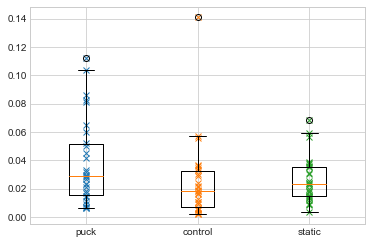

In [12]:
data = [p1_trimmed_data,p2_trimmed_data,p3_trimmed_data,p4_trimmed_data,p5_trimmed_data]

# Ensure we have the expected number for each hand rep
hand_rep_counts = defaultdict(int)
for participant_data in data:
    for trial_data in participant_data:
        hand_rep_counts[trial_data['hand_rep']] += 1
print("Validation:")
print(hand_rep_counts)

dist_by_hand_rep = defaultdict(list)
for participant_data in data:
    for trial_data in participant_data:
        dist_by_hand_rep[trial_data['hand_rep']].append(dist(trial_data['object_events']))

print("\nBasic Stats:")
for hand_rep, dists in dist_by_hand_rep.items():
    print(hand_rep, "-  mean", statistics.mean(dists), "  median", statistics.median(dists))
    
print("\nBox Plots:")
vals = []
tick_names = []
for i, (hand_rep, dists) in enumerate(dist_by_hand_rep.items()):
    vals.append(dists)
    tick_names.append(hand_rep)
    plt.plot([i] * len(dists), dists, 'x')
plt.boxplot(vals, positions=list(range(len(vals))))
plt.xticks(list(range(len(vals))), tick_names)
pass

### By Object Rep

Validation:
defaultdict(<class 'int'>, {'control': 30, 'heatmap': 30, 'shell': 30})

Basic Stats:
control -  mean 0.025412756893836756   median 0.019835373219725533
heatmap -  mean 0.02934832264644717   median 0.025445059773069965
shell -  mean 0.0330032947071026   median 0.020958154233862054

Box Plots:


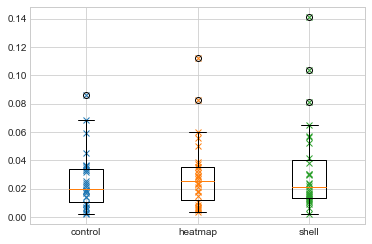

In [13]:
data = [p1_trimmed_data,p2_trimmed_data,p3_trimmed_data,p4_trimmed_data,p5_trimmed_data]

# Ensure we have the expected number for each object rep
object_rep_counts = defaultdict(int)
for participant_data in data:
    for trial_data in participant_data:
        object_rep_counts[trial_data['object_rep']] += 1
print("Validation:")
print(object_rep_counts)

dist_by_object_rep = defaultdict(list)
for participant_data in data:
    for trial_data in participant_data:
        dist_by_object_rep[trial_data['object_rep']].append(dist(trial_data['object_events']))

print("\nBasic Stats:")
for object_rep, dists in dist_by_object_rep.items():
    print(object_rep, "-  mean", statistics.mean(dists), "  median", statistics.median(dists))
    
print("\nBox Plots:")
vals = []
tick_names = []
for i, (object_rep, dists) in enumerate(dist_by_object_rep.items()):
    vals.append(dists)
    tick_names.append(object_rep)
    plt.plot([i] * len(dists), dists, 'x')
plt.boxplot(vals, positions=list(range(len(vals))))
plt.xticks(list(range(len(vals))), tick_names)
pass

### By Object Type

Validation:
defaultdict(<class 'int'>, {'cup': 45, 'controller': 45})

Basic Stats:
cup -  mean 0.03484287789126216   median 0.030161034081068475
controller -  mean 0.023666704940328857   median 0.018051547282562697

Box Plots:


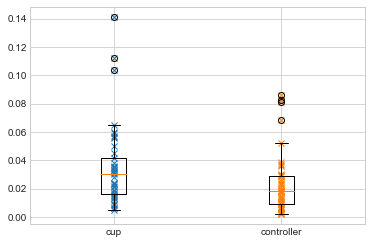

In [14]:
data = [p1_trimmed_data,p2_trimmed_data,p3_trimmed_data,p4_trimmed_data,p5_trimmed_data]

# Ensure we have the expected number for each object type
object_type_counts = defaultdict(int)
for participant_data in data:
    for trial_data in participant_data:
        object_type_counts[trial_data['object_type']] += 1
print("Validation:")
print(object_type_counts)

dist_by_object_type = defaultdict(list)
for participant_data in data:
    for trial_data in participant_data:
        dist_by_object_type[trial_data['object_type']].append(dist(trial_data['object_events']))

print("\nBasic Stats:")
for object_type, dists in dist_by_object_type.items():
    print(object_type, "-  mean", statistics.mean(dists), "  median", statistics.median(dists))
    
print("\nBox Plots:")
vals = []
tick_names = []
for i, (object_type, dists) in enumerate(dist_by_object_type.items()):
    vals.append(dists)
    tick_names.append(object_type)
    plt.plot([i] * len(dists), dists, 'x')
plt.boxplot(vals, positions=list(range(len(vals))))
plt.xticks(list(range(len(vals))), tick_names)
pass

# Rotation Offset

In [26]:
def dot_product(v1, v2):
    return sum(i[0] * i[1] for i in zip(v1, v2))

# Based on https://math.stackexchange.com/questions/90081/quaternion-distance
def quat_angle_diff(q1, q2):
    inner = 2*(dot_product(q1, q2)**2) - 1
    if inner > 1:
#         print("buggy inner?", inner)
        inner = 1
    if inner < -1:
#         print("buggy inner?", inner)
        inner = -1
    return math.degrees(math.acos(inner))

# From https://stackoverflow.com/a/28526156
def rot_to_quat(rx, ry, rz):
    yaw = math.radians(rx)
    pitch = math.radians(ry)
    roll = math.radians(rz)
    
    cy = math.cos(yaw/2)
    sy = math.sin(yaw/2)
    cp = math.cos(pitch/2)
    sp = math.sin(pitch/2)
    cr = math.cos(roll/2)
    sr = math.sin(roll/2)
    
    return [
        cy*cp*cr + sy*sp*sr,
        sy*cp*cr + cy*sp*sr,
        cy*sp*cr - sy*cp*sr,
        cy*cp*sr - sy*sp*cr,
    ]

def rot(events):
    max_rot = 0
    first_event = None
    for e in events:
        if not first_event:
            first_event = e
        rot = quat_angle_diff(
            rot_to_quat(first_event['rx'], first_event['ry'], first_event['rz']),
            rot_to_quat(e['rx'], e['ry'], e['rz']),
        )
        max_rot = max(rot, max_rot)
    return max_rot

In [33]:
data = [p1_trimmed_data,p2_trimmed_data,p3_trimmed_data,p4_trimmed_data,p5_trimmed_data]

def plot_by_key(data, key):
    # Ensure we have the expected number for each hand rep
    key_counts = defaultdict(int)
    for participant_data in data:
        for trial_data in participant_data:
            key_counts[trial_data[key]] += 1
    print("Validation:")
    print(key_counts)

    rot_by_key = defaultdict(list)
    for participant_data in data:
        for trial_data in participant_data:
            rot_by_key[trial_data[key]].append(rot(trial_data['object_events']))

    print("\nBasic Stats:")
    for key, rots in rot_by_key.items():
        print(key, "-  mean", statistics.mean(rots), "  median", statistics.median(rots))

    print("\nBox Plots:")
    vals = []
    tick_names = []
    for i, (key, rots) in enumerate(rot_by_key.items()):
        vals.append(rots)
        tick_names.append(key)
        plt.plot([i] * len(rots), rots, 'x')
    plt.boxplot(vals, positions=list(range(len(vals))))
    plt.xticks(list(range(len(vals))), tick_names)
    pass

Validation:
defaultdict(<class 'int'>, {'p1': 18, 'p2': 18, 'p3': 18, 'p4': 18, 'p5': 18})

Basic Stats:
p1 -  mean 19.354292303476008   median 13.303009693807539
p2 -  mean 11.234324676587782   median 8.70324375397651
p3 -  mean 9.954842471006831   median 7.816327822015003
p4 -  mean 8.736088272144416   median 6.9078181779822705
p5 -  mean 5.036414819384792   median 4.674384212506397

Box Plots:


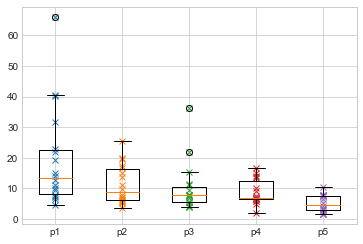

In [34]:
plot_by_key(data, 'participant')

Validation:
defaultdict(<class 'int'>, {'puck': 30, 'control': 30, 'static': 30})

Basic Stats:
puck -  mean 13.370521427598083   median 7.807862755192829
control -  mean 9.414659782759154   median 7.528053643338215
static -  mean 9.804396315202661   median 7.648946999012836

Box Plots:


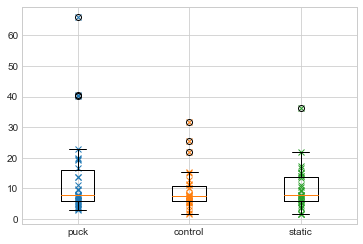

In [35]:
plot_by_key(data, 'hand_rep')

Validation:
defaultdict(<class 'int'>, {'control': 30, 'heatmap': 30, 'shell': 30})

Basic Stats:
control -  mean 8.744368731418296   median 6.475369331865181
heatmap -  mean 11.790372295435947   median 7.865992665997416
shell -  mean 12.054836498705653   median 8.755921873839739

Box Plots:


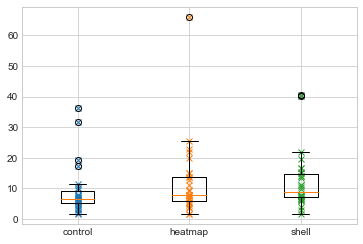

In [36]:
plot_by_key(data, 'object_rep')

Validation:
defaultdict(<class 'int'>, {'cup': 45, 'controller': 45})

Basic Stats:
cup -  mean 9.650773504580462   median 6.754692127163618
controller -  mean 12.075611512459469   median 7.950906068755583

Box Plots:


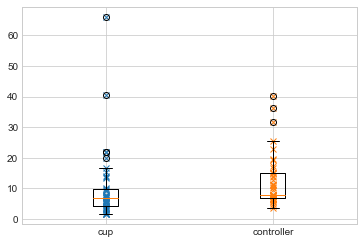

In [28]:
plot_by_key(data, 'object_type')